# EDA
##### _Exploratory Data Analysis_

Анализ сервиса - "Автоподписка" (долгосрочная аренда автомобилей для физлиц)

Проверка гипотез:

* Органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события.
* Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR (Conversion Rate) в целевые события.
* Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR (Conversion Rate) в целевые события.


Вопросы:

* Из каких источников / кампаний / устройств / локаций к нам идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?
* Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?
* Стоит ли нам увеличивать своё присутствие в соцсетях и давать там больше рекламы?

Загрузка библиотек

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
pd.set_option('display.float_format', '{:.10f}'.format) # отображение с 10 знаками после запятой для чисел с плавающей точкой

In [3]:
from IPython.core.display import display, HTML

display(HTML("""
<style>
    .output_scroll {
        height: auto !important;
        max-height: 1000px; /* Вы можете изменить это значение */
    }
</style>
"""))

C:\Users\Колонтай\AppData\Local\Temp\ipykernel_3452\3023473509.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Подготовка данных

In [4]:
df = pd.read_pickle('./data/ga_sessions.pkl')
df_hits = pd.read_pickle('./data/ga_hits.pkl')
action = [
    'sub_car_claim_click', 
    'sub_car_claim_submit_click',
    'sub_open_dialog_click', 
    'sub_custom_question_submit_click',
    'sub_call_number_click', 
    'sub_callback_submit_click', 
    'sub_submit_success',
    'sub_car_request_submit_click'
]

#добавим метку - произошло ли целевое действие в рамках процедуры 1 -да, 0 - нет
df_hits['is_action'] = df_hits['event_action'].isin(action).astype(int)
# создадим таблицу где указано было ли целевое действие в рамках сессии у клиента
df_action_session  = df_hits.groupby(['session_id','client_id'],as_index = False).agg(is_action = ('is_action',max))
# добавим в таблицу df целевую переменную 
df = df.merge(df_action_session[['session_id', 'is_action']], on='session_id', how='left')

#добавим iD клиентов в df_hits
df_hits = df_hits.merge(df[['session_id', 'client_id']], on='session_id', how='left')







Описание данных 

In [5]:
df.describe()
def getDescription(df): 
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all',percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
).transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['1%'] = desc.loc[:, '1%'].values
    summ['5%'] = desc.loc[:, '5%'].values
    summ['25%'] = desc.loc[:, '25%'].values
    summ['50%'] = desc.loc[:, '50%'].values
    summ['75%'] = desc.loc[:, '75%'].values
    summ['95%'] = desc.loc[:, '95%'].values
    summ['99%'] = desc.loc[:, '99%'].values
    return summ

Проверка гипотез

In [6]:
organic = ('organic', 'referral', '(none)')
df['is_organic'] = df['utm_medium'].isin(organic)

mobile = ['mobile','tablet']
df['is_mobile'] = df['device_category'].isin(mobile)

MO_SPB = ['Moscow','Saint Petersburg']
df['is_MO_SPB'] = df['geo_city'].isin(MO_SPB)

geo_city_df =df.groupby('geo_city',as_index=False).agg(cnt = ('geo_city','count')).sort_values(by=['cnt'],ascending =False)
other_cities = list(geo_city_df[(geo_city_df.cnt>5000)].geo_city)
df['geo_city_2'] = np.where(df.geo_city.isin(other_cities),df.geo_city,'other_cities')


def Xi_test(feature, target, alpha):
    
    # Хи-квадрат тест
    from scipy.stats import chi2_contingency
    crosstab = pd.crosstab(df[feature], df[target])
    chi2, p_value, dof, expected = chi2_contingency(crosstab)


    print('p-value: ', p_value)
    
    if p_value < alpha:
        print("Мы отвергаем нулевую гипотезу, так как p-value < 0.05. Значит, есть статистически значимые различия.")
    else:
        print("Мы не можем отвергнуть нулевую гипотезу, так как p-value >= 0.05. Значит, статистически значимых различий нет.")  

def conv_rate(feature):
    crosstab = pd.crosstab(df[feature], df['is_action'],normalize ='index')
    for i in range(len(crosstab.index)):
        print(f'Показатель конверсии {crosstab.index[i]} : {round(crosstab[1][i]*100,2)}%')

In [22]:
print ('Тест Гипотезы о равенстве конверсии органического и неорганического трафика')
Xi_test('is_organic','is_action',0.05)
print('')
print('Конверсия органического трафика:')
conv_rate('is_organic')

print('')
print('---------------------------')

print ('Тест Гипотезы о равенстве конверсии мобильных и десктопных устройств')
Xi_test('is_mobile','is_action',0.05)
print('')
print('Конверсия по мобильным устройствам:')
conv_rate('device_category')

print('')
print('---------------------------')

print ('Тест Гипотезы о равенстве конверсии из Москвы,СПб и других городов')
Xi_test('is_MO_SPB','is_action',0.05)
print('')
print('Конверсия из городов с наибольшим числом целевых действий:')
conv_rate('geo_city_2')


Тест Гипотезы о равенстве конверсии органического и неорганического трафика
p-value:  0.0
Мы отвергаем нулевую гипотезу, так как p-value < 0.05. Значит, есть статистически значимые различия.

Конверсия органического трафика:
Показатель конверсии False : 2.34%
Показатель конверсии True : 4.44%

---------------------------
Тест Гипотезы о равенстве конверсии мобильных и десктопных устройств
p-value:  2.3901156687792695e-59
Мы отвергаем нулевую гипотезу, так как p-value < 0.05. Значит, есть статистически значимые различия.

Конверсия по мобильным устройствам:
Показатель конверсии desktop : 3.32%
Показатель конверсии mobile : 2.8%
Показатель конверсии tablet : 2.53%

---------------------------
Тест Гипотезы о равенстве конверсии из Москвы,СПб и других городов
p-value:  7.242120283733323e-15
Мы отвергаем нулевую гипотезу, так как p-value < 0.05. Значит, есть статистически значимые различия.

Конверсия из городов с наибольшим числом целевых действий:
Показатель конверсии (not set) : 2.17%
П

Конверсия и размер трафика сессий по всем категориям (топ 15 по каждой, по размеру трафика)


По категории utm_source:




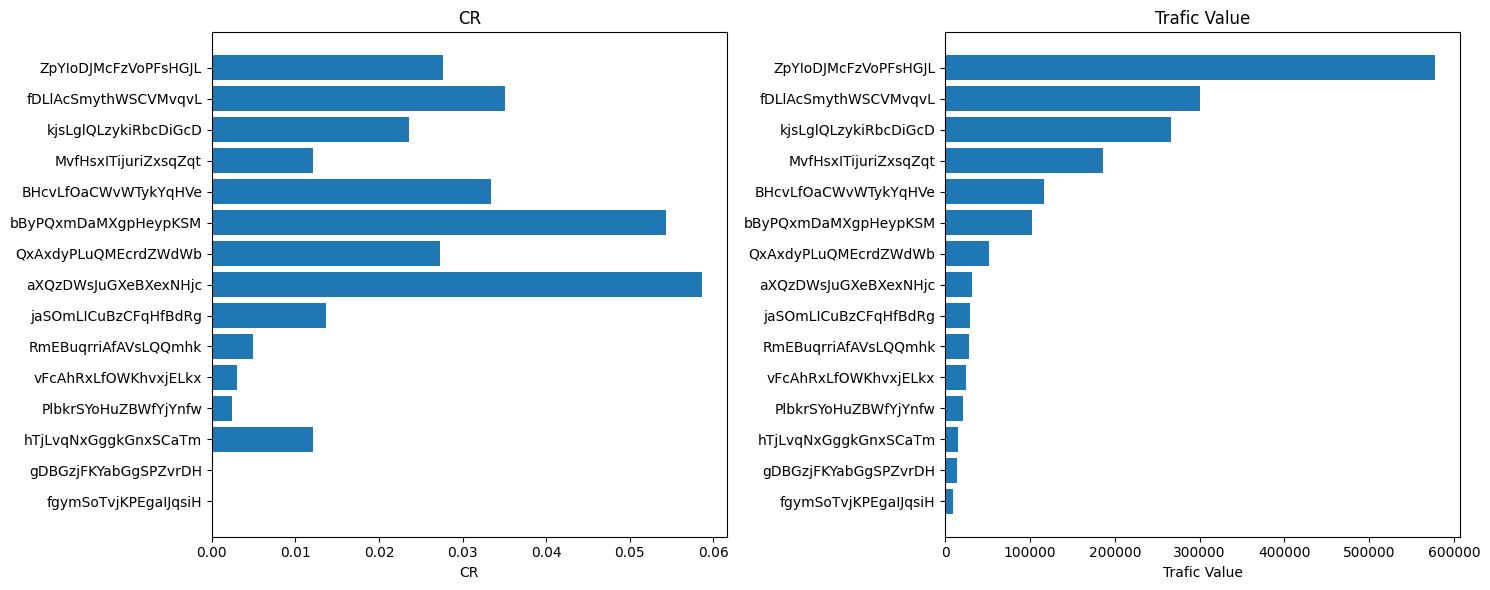

--------------------------------------------------------------------------------------------------------------------------

По категории utm_medium:




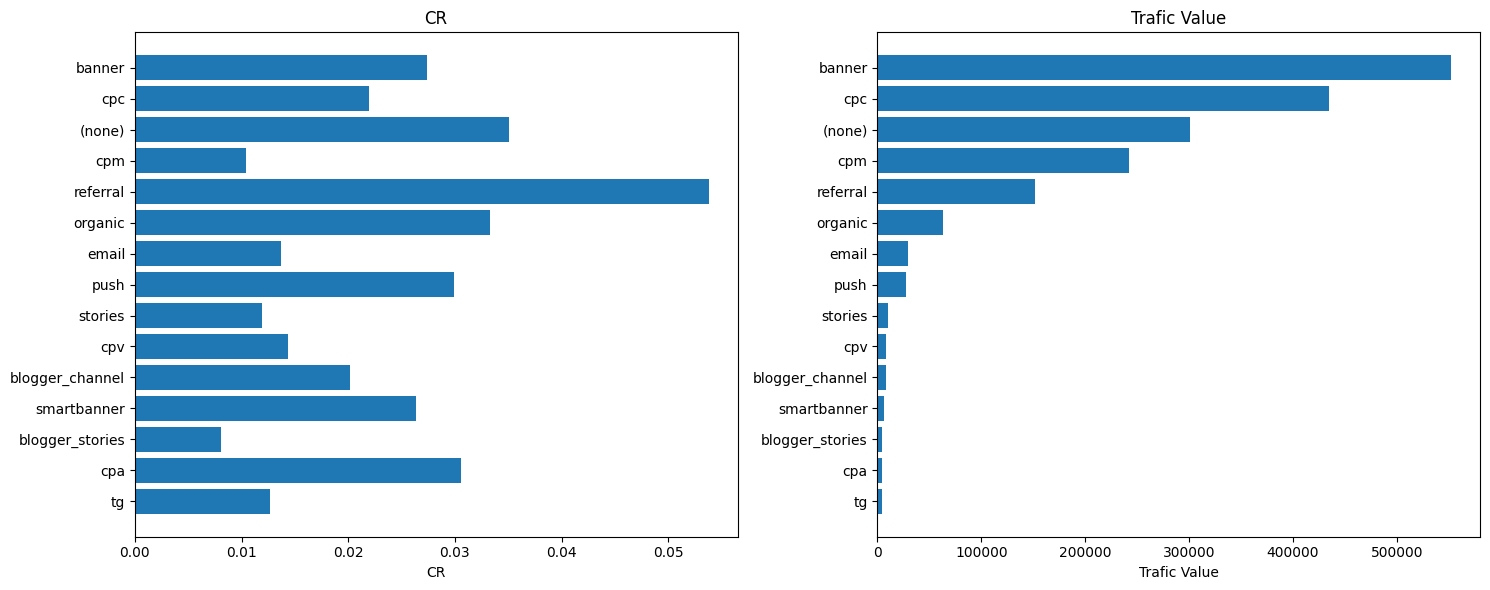

--------------------------------------------------------------------------------------------------------------------------

По категории utm_campaign:




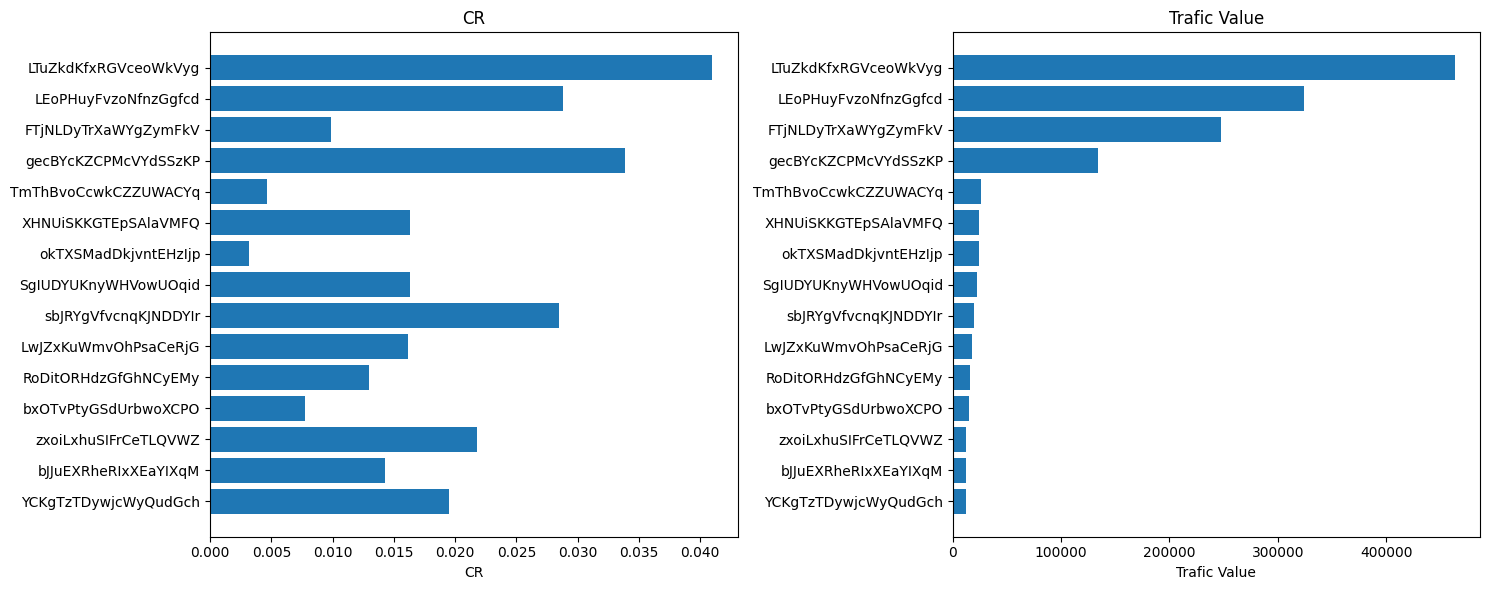

--------------------------------------------------------------------------------------------------------------------------

По категории device_category:




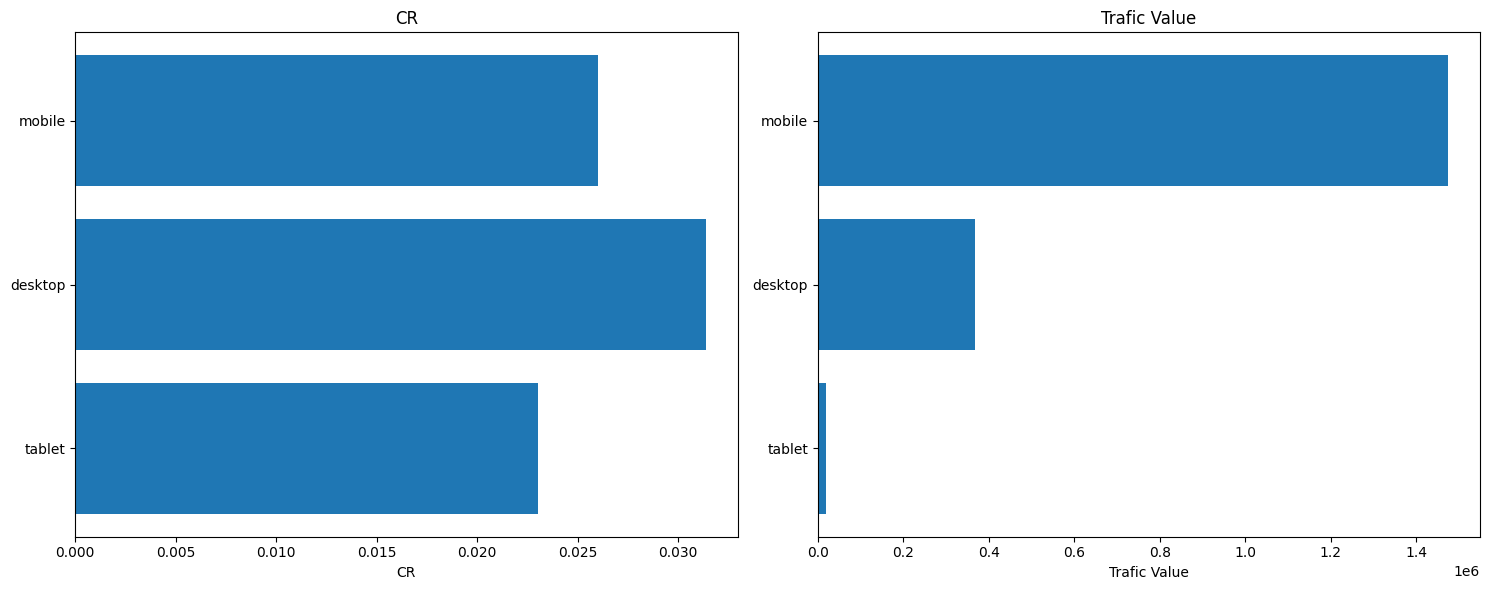

--------------------------------------------------------------------------------------------------------------------------

По категории device_os:




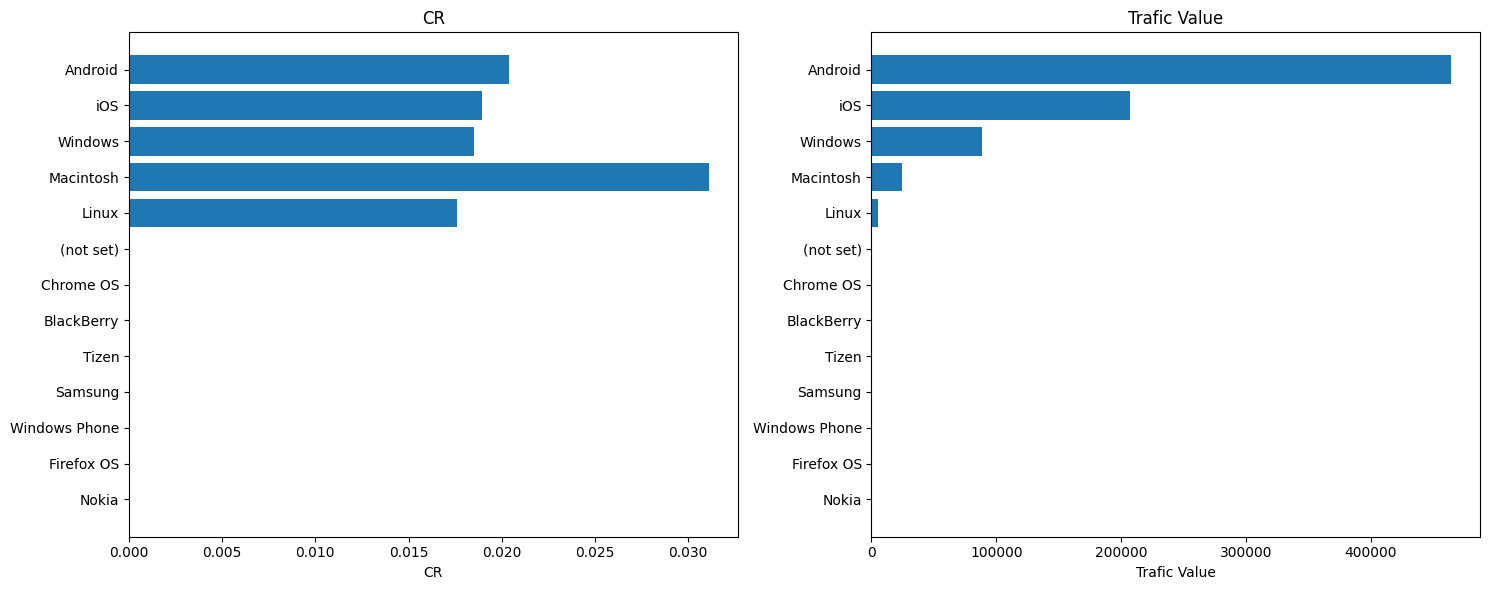

--------------------------------------------------------------------------------------------------------------------------

По категории device_brand:




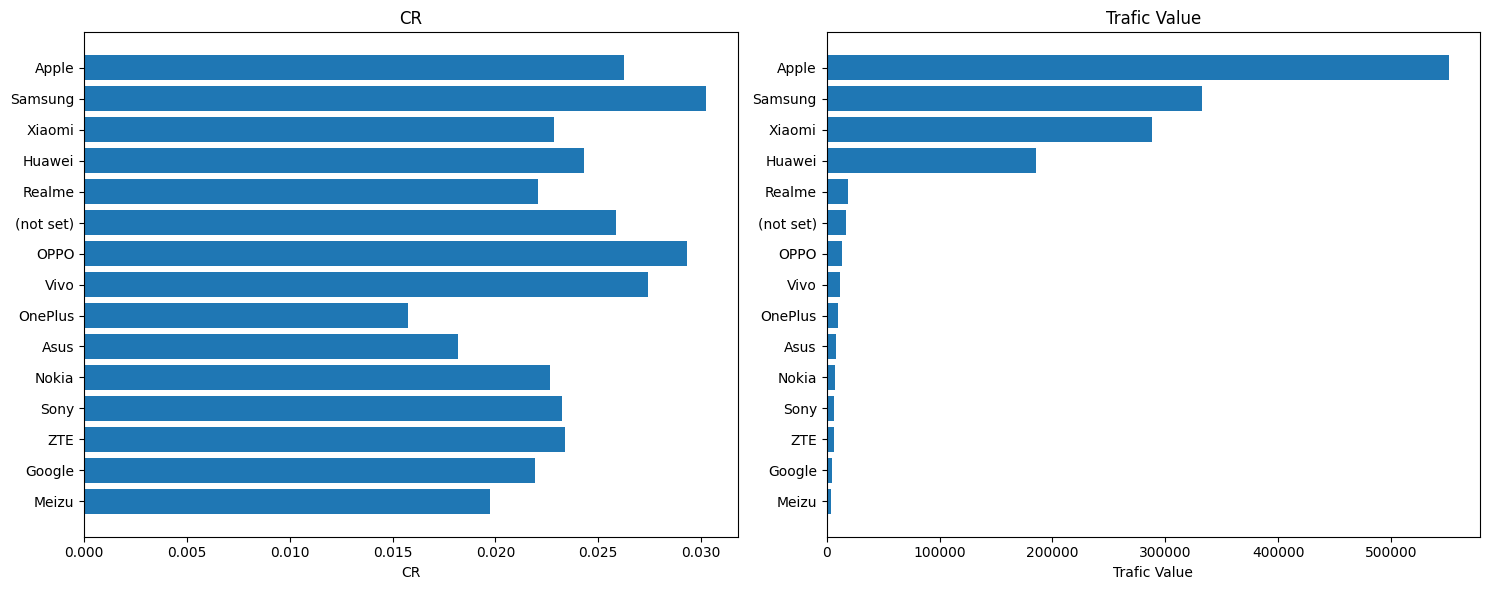

--------------------------------------------------------------------------------------------------------------------------

По категории device_model:




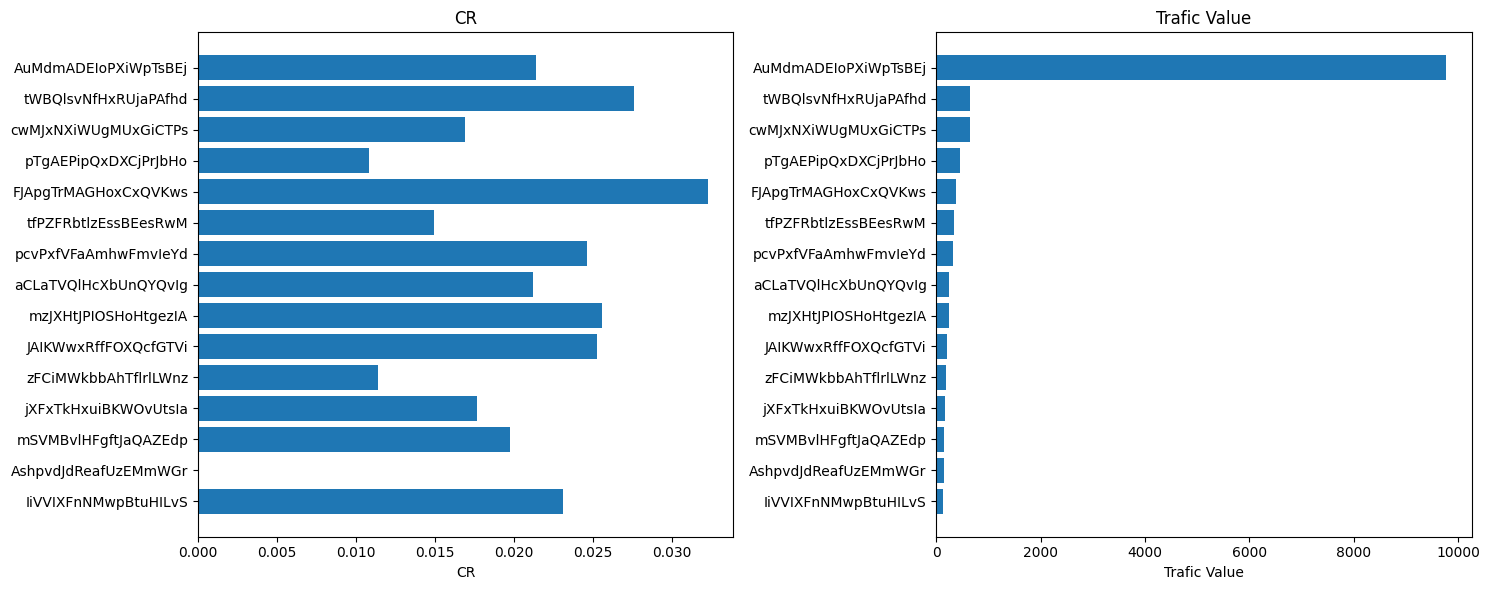

--------------------------------------------------------------------------------------------------------------------------

По категории device_browser:




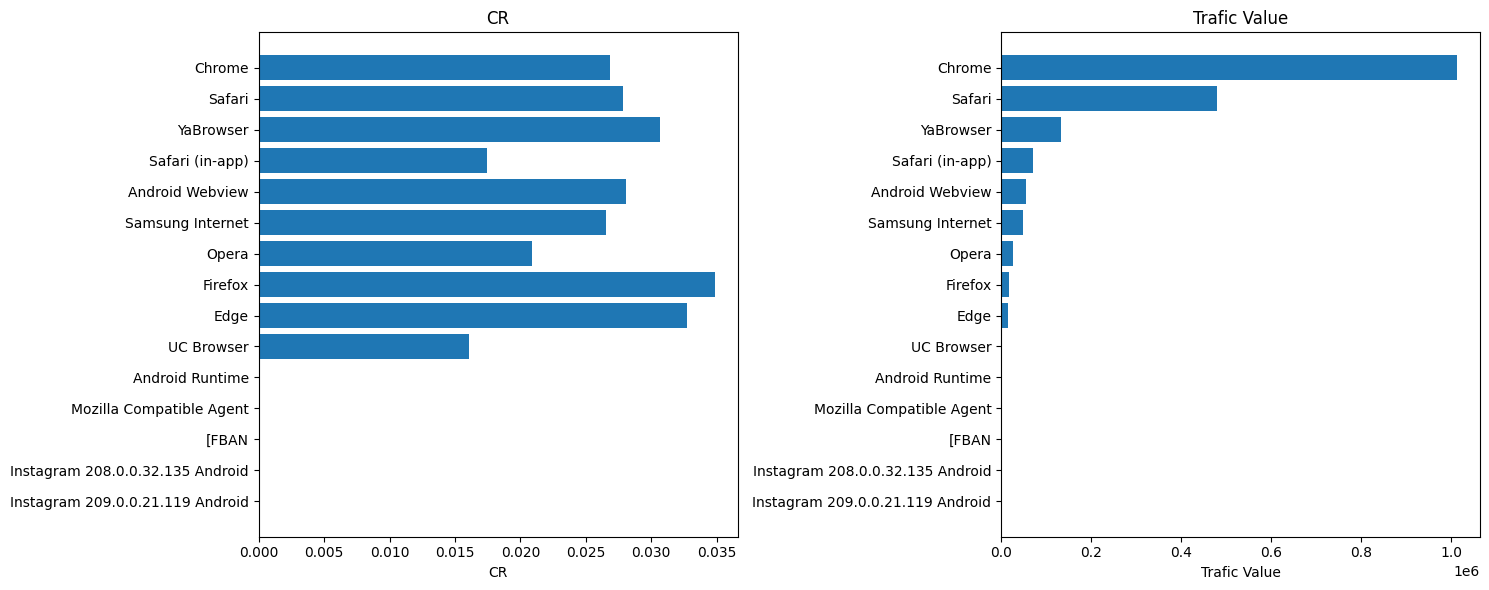

--------------------------------------------------------------------------------------------------------------------------

По категории geo_country:




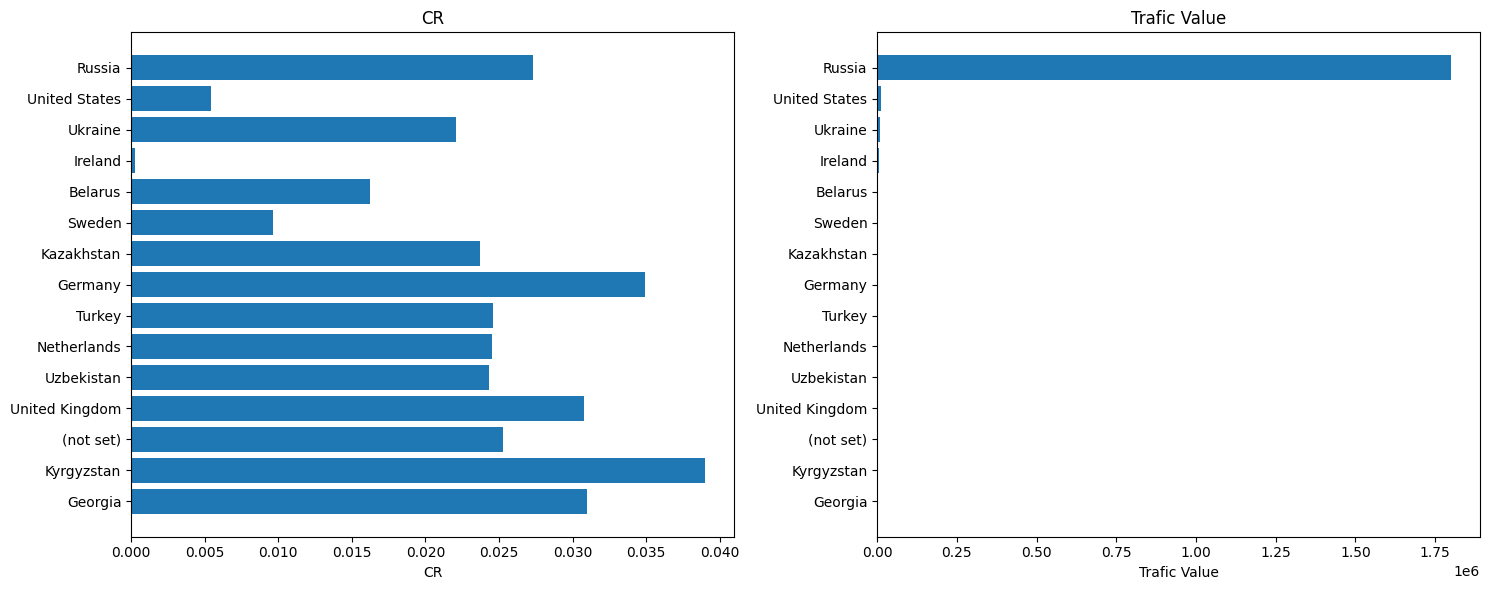

--------------------------------------------------------------------------------------------------------------------------

По категории geo_city:




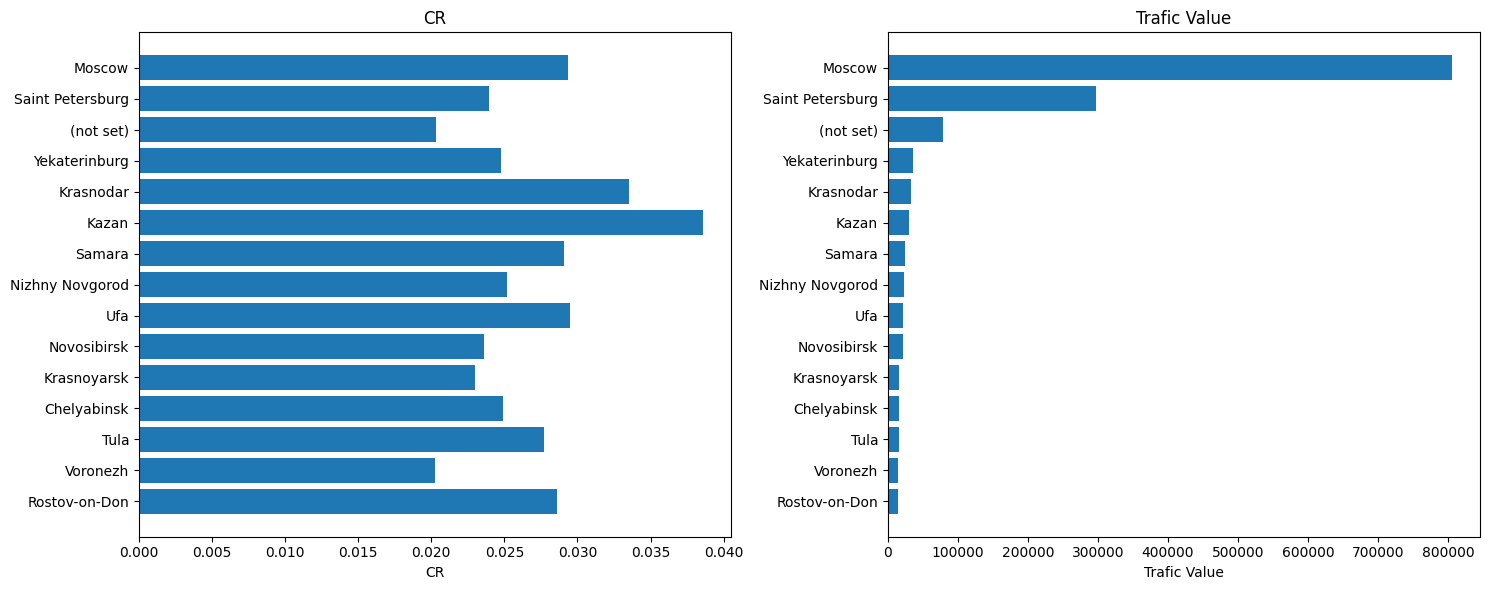

--------------------------------------------------------------------------------------------------------------------------


In [8]:
analisys_features = ['utm_source', 'utm_medium', 'utm_campaign', 'device_category', 'device_os', 'device_brand', 'device_model', 'device_browser', 'geo_country', 'geo_city']
CR = pd.DataFrame(columns=['analisys_features', 'feature', 'cr','trafic_value'])
results = []

for feature in analisys_features:
    # Группируем данные по признаку и считаем количество сессий и конверсий
    group = df.groupby(feature).agg(
        trafic_value=('session_id', 'count'),
        conversions=('is_action', sum)
    ).reset_index()

    # Вычисляем коэффициент конверсии
    group['cr'] = group['conversions'] / group['trafic_value']
    group['analisys_features'] = feature

    # Добавляем результаты в список
    results.append(group[['analisys_features', feature, 'cr', 'trafic_value']])
    
    group = group[['analisys_features', feature, 'cr', 'trafic_value']].rename(columns={feature: "feature"}).sort_values(by =['trafic_value'], ascending = False).head(15)
    
    print ('')
    print (f'По категории {feature}:')
    print ('')
    print ('')
    x_values1 = group['feature']
    y_values1 = group['cr']


    x_values2 = group['feature']
    y_values2 = group['trafic_value']
    fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 


    ax[0].barh(x_values1, y_values1)
    ax[0].set_title('CR')
    ax[0].set_xlabel('CR')
    ax[0].invert_yaxis()


    ax[1].barh(x_values2, y_values2)
    ax[1].set_title('Trafic Value')
    ax[1].set_xlabel('Trafic Value')
    ax[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print ('--------------------------------------------------------------------------------------------------------------------------')
    
    CR = pd.concat([CR,group], ignore_index=True)
    


Проанализируем просмотры различных автомобилей и конверсию в целевые события.

In [9]:
# вытаскиваем марку и модель авто из описания ссылки
mask = df_hits['hit_page_path'].str.contains('all/')
split_df = df_hits.loc[mask, 'hit_page_path'].str.split('all/',expand=True)[1].str.split('/', expand=True).loc[:,:1]
df_hits.loc[mask,'car_model'] = split_df[0] + " " + split_df[1]
df_hits['car_model'] = df_hits['car_model'].fillna(0)

df_cars = df_hits.groupby('car_model',as_index =False).agg(action =('is_action','sum'), trafic_value =('is_action','count'))
df_cars['cr'] = df_cars['action']/df_cars['trafic_value']
df_cars = df_cars[df_cars.car_model!=0]



In [10]:
print('Топ 20 Наиболее популярных авто по всем событиям')
print('')
print(df_cars.sort_values('trafic_value',ascending=False).reset_index().loc[:20,['car_model','trafic_value']])

Топ 20 Наиболее популярных авто по всем событиям

                   car_model  trafic_value
0                skoda rapid        442513
1             lada-vaz vesta        403910
2            volkswagen polo        318075
3                skoda karoq        194273
4     mercedes-benz e-klasse        178467
5             nissan qashqai        153153
6                    kia rio         90249
7             nissan x-trail         85548
8              skoda octavia         77005
9             renault duster         76676
10              toyota camry         73149
11             renault logan         72088
12                kia seltos         70464
13               kia sorento         69886
14         volkswagen tiguan         62101
15         mercedes-benz glb         61043
16  mercedes-benz gla-klasse         55236
17                 volvo s90         51627
18              haval jolion         51538
19               bmw 5-serii         40453
20    mercedes-benz g-klasse         40113


In [11]:
print('Топ 20 по показателю CR (Conversion Rate) в целевые события')
print('')
print(df_cars.sort_values('cr',ascending=False).reset_index().loc[:20,['car_model','cr']])

Топ 20 по показателю CR (Conversion Rate) в целевые события

                       car_model           cr
0                         bmw x1 0.0919540230
1                  infiniti qx60 0.0853080569
2                       bmw x3-m 0.0823529412
3                 renault arkana 0.0766384778
4                       bmw x4-m 0.0485436893
5           volkswagen passat-cc 0.0454545455
6                   toyota rav-4 0.0318627451
7   land-rover range-rover-velar 0.0254237288
8                hyundai solaris 0.0244568070
9                     kia cerato 0.0220553731
10                        bmw x5 0.0196346141
11                 porsche macan 0.0187793427
12            honda civic-type-r 0.0176322418
13                       kia rio 0.0159336946
14                  toyota camry 0.0156529823
15               volkswagen polo 0.0145688910
16                   skoda rapid 0.0136267183
17                lada-vaz vesta 0.0132603798
18                 renault logan 0.0123876373
19                 

Проанализируем трафик от социальных сетей

In [12]:
social = ('QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs','IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw','gVRrcxiDQubJiljoTbGm')
#df['utm_source'].fillna('unknown', inplace=True)
df['is_social'] = df['utm_source'].isin(social)

In [13]:
print ('Тест Гипотезы о равенстве конверсии от сессий с источником социальных сетей и не социальных сетей')
Xi_test('is_social','is_action',0.05)
print('')
print('Конверсия по социальным сетям:')
conv_rate('is_social')

Тест Гипотезы о равенстве конверсии от сессий с источником социальных сетей и не социальных сетей
p-value:  0.0
Мы отвергаем нулевую гипотезу, так как p-value < 0.05. Значит, есть статистически значимые различия.

Конверсия по социальным сетям:
Показатель конверсии False : 3.14%
Показатель конверсии True : 1.57%


Конверсия от социальных сетей в 2 раза ниже, чем коверсия от прочих источников. И кажется, что увеличивать присутствие в соц.сетях не стоит. Однако, чтобы ответить на данный вопрос более точно, необходимо более детально проанализировать "Прочие источники", в том числе в привязке со стоимостью получения трафика.

Общая функция для СR и Трафика

In [14]:
def cr_analisys(df,feature):
    df_f = df.groupby(feature,as_index =False).agg(action =('is_action','sum'), trafic_value =('is_action','count'))
    df_f['cr'] = df_f['action']/df_f['trafic_value']
    df_f['action']= df_f['action'].astype('int32')
    df_f['cr']= df_f['cr'].fillna(0)
    df_f['cr'] = df_f['cr']*100
    #df_f= df_f.sort_values('cr',ascending = False)
    df_f['trafic_part'] = df_f['trafic_value']/df_f['trafic_value'].sum() 
    df_f = df_f.sort_values('trafic_part',ascending = False)
    df_f['cumulative_sum'] = df_f['trafic_part'].cumsum()

    return df_f

def show_diag(df,feature):
    df = df.head(20)
    print(f'По категории {feature}:')
    print('')

    x_values1 = df[feature]
    y_values1 = df['cr']

    x_values2 = df[feature]
    y_values2 = df['trafic_value']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)  # Общая ось Y

    ax1.barh(x_values1, -y_values1)  
    ax1.set_title('CR')
    ax1.set_xlabel('CR')
    ax1.invert_xaxis()  
    ax1.grid(True)

    ax2.barh(x_values2, y_values2)
    ax2.set_title('Trafic Value')
    ax2.set_xlabel('Trafic Value')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()